In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import winsound  # Importa el módulo para Windows
import os 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df=pd.read_csv('flordatav2.csv')
df['fecha']=pd.to_datetime(df['fecha'])
df['mes'] = df['fecha'].dt.to_period('M')
df_grouped = df.groupby(['mes', 'variedad']).agg({'produccion': 'sum', 'ventas': 'sum'}).reset_index()
df_ventas = df_grouped.pivot(index='mes', columns='variedad', values='ventas').fillna(0)
df_produccion = df_grouped.pivot(index='mes', columns='variedad', values='produccion').fillna(0)

In [3]:
train_data_ventas = df_ventas.loc['2020':'2022']
train_data_produccion = df_produccion.loc['2020':'2022']
test_data_ventas = df_ventas.loc['2023-01':'2023-12']
test_data_produccion = df_produccion.loc['2023-01':'2023-12']

In [4]:
predicciones_2023_id = []
resultados_errores = []
train_losses = []
val_losses = []
#variedad='MONDIAL'
for variedad in df_ventas.columns:
    endogena_train = train_data_ventas[variedad]
    exogena_train = train_data_produccion[variedad]
    endogena_test = test_data_ventas[variedad]
    exogena_test = test_data_produccion[variedad]

    modelo = Sequential()
    modelo.add(LSTM(64,activation='relu',input_shape=(1, 2)))
    modelo.add(Dropout(0.01))
    modelo.add(Dense(16,activation='relu'))
    #modelo.add(Dense(16,activation='relu'))
    modelo.add(Dense(1,activation='linear'))
    modelo.compile(optimizer='adam', loss='mse',metrics=['mae'])

    train_generator = TimeseriesGenerator(np.column_stack((exogena_train, endogena_train)), endogena_train, length=1, batch_size=1)
    test_generator = TimeseriesGenerator(np.column_stack((exogena_test, endogena_test)), endogena_test, length=1, batch_size=1)  

    result = modelo.fit_generator(train_generator, epochs=100, verbose=0,validation_data=test_generator)
    train_loss = result.history['loss']
    train_losses.append({'variedad':variedad,'perdida':train_loss})
    val_loss = result.history['val_loss']
    val_losses.append({'variedad':variedad,'perdida':val_loss})
    # Predecir 12 puntos de datos para 2023
    pred_2023 = modelo.predict_generator(test_generator)

    # Generar una predicción adicional para el último punto de tiempo en 2023
    ultimo_punto_2023 = modelo.predict(
        np.array([exogena_test[-1], endogena_test[-1]]).reshape(1, 1, 2))
    pred_2023 = np.concatenate((pred_2023, ultimo_punto_2023))
    rmse = np.sqrt(np.mean((pred_2023.flatten() - endogena_test)**2))
    mae = np.mean(np.abs(pred_2023.flatten() - endogena_test))
    mape = np.mean(np.abs((pred_2023.flatten() - endogena_test) / endogena_test))

        # Almacenamiento de resultados de errores
    resultados_errores.append({"variedad": variedad, "rmse": rmse, "mae": mae, "mape": mape})

    # Guardar predicciones para 2023
    predicciones_variedad_2023 = {'variedad': variedad, 'predicciones_2023': pred_2023.flatten()}
    predicciones_2023_id.append(predicciones_variedad_2023)
winsound.Beep(2500, 1000)  # Emite un pitido al finalizar el script



C:\Users\andre\AppData\Local\Temp\ipykernel_68896\1751664922.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = modelo.fit_generator(train_generator, epochs=100, verbose=0,validation_data=test_generator)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\sequence.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


C:\Users\andre\AppData\Local\Temp\ipykernel_68896\1751664922.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_2023 = modelo.predict_generator(test_generator)
C:\Users\andre\AppData\Local\Temp\ipykernel_68896\1751664922.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.array([exogena_test[-1], endogena_test[-1]]).reshape(1, 1, 2))


1/1 [==============================] - 0s 178ms/step


In [5]:
# Convertir la lista de resultados de errores en un DataFrame
errores_df = pd.DataFrame(resultados_errores)

# Crear DataFrame para almacenar las predicciones para 2023
predicciones_2023_df = pd.DataFrame(index=pd.date_range(start='2023', periods=12, freq='M'))

for result in predicciones_2023_id:
    variedad = result["variedad"]
    pred_2023 = result["predicciones_2023"]
    predicciones_2023_df[variedad] = pred_2023

C:\Users\andre\AppData\Local\Temp\ipykernel_68896\418707123.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicciones_2023_df = pd.DataFrame(index=pd.date_range(start='2023', periods=12, freq='M'))


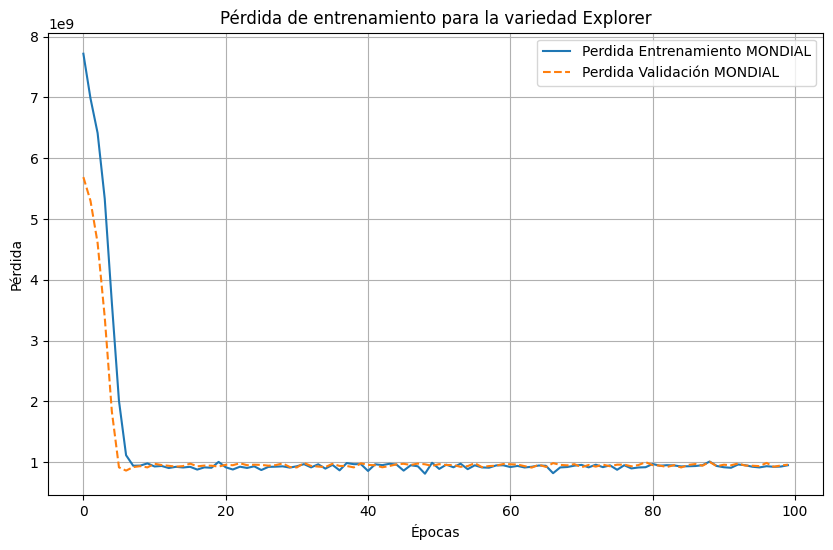

In [6]:
import matplotlib.pyplot as plt

# Suponiendo que `train_losses` es una lista de diccionarios que contiene los resultados de entrenamiento de cada variedad

# Filtrar los resultados de entrenamiento solo para la variedad "EXPLORER"
train_losses_explorer = [result for result in train_losses if result["variedad"] == "MONDIAL"]
val_losses_explorer = [result for result in val_losses if result["variedad"] == "MONDIAL"]

# Crear una figura y ejes
plt.figure(figsize=(10, 6))

# Trazar la pérdida de entrenamiento de la variedad "EXPLORER"
for result in train_losses_explorer:
    perdida = result["perdida"]
    plt.plot(perdida, label="Perdida Entrenamiento MONDIAL")

for result in val_losses_explorer:
    perdida = result["perdida"]
    plt.plot(perdida, label="Perdida Validación MONDIAL",linestyle='dashed')

# Configurar el título y etiquetas de los ejes
plt.title('Pérdida de entrenamiento para la variedad Explorer')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
errores_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
print('Errores promedios de ventas totales')
print('mae',errores_df['mae'].mean())
print('rmse',errores_df['rmse'].mean())
print('mape',errores_df['mape'].mean())

Errores promedios de ventas totales
mae 2597.2892071342976
rmse 3131.7497060229343
mape 0.16399330796627803


In [9]:
print('Errores variedad MONDIAL')
errores_df[errores_df['variedad']=='MONDIAL']

Errores variedad MONDIAL


,variedad,rmse,mae,mape
33,MONDIAL,4046.014212,3244.854492,0.044709


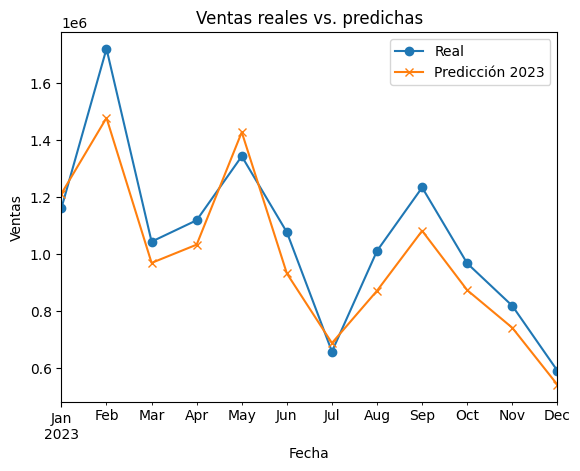

In [10]:
test_data_ventas.sum(axis=1).plot(label='Real',marker='o'  )
predicciones_2023_df.sum(axis=1).plot(label='Predicción 2023',marker='x')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas reales vs. predichas')
plt.legend()

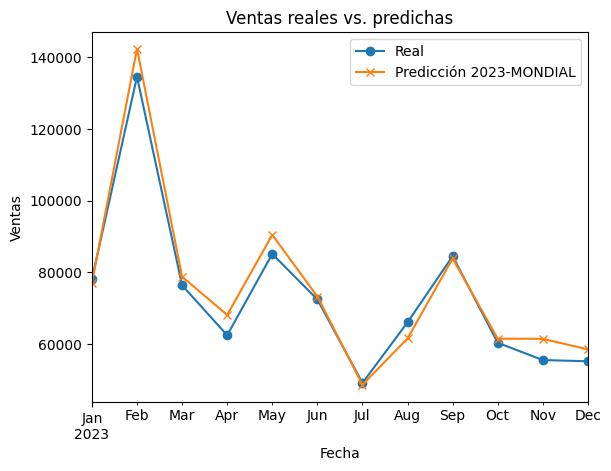

In [30]:
df_ventas['MONDIAL'].loc['2023'].plot(label='Real',marker='o'  )
predicciones_2023_df['MONDIAL'].plot(label='Predicción 2023-MONDIAL',marker='x')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas reales vs. predichas')
plt.legend()

In [12]:
train_data_ventas = df_ventas.loc['2020-10':'2023-09']
train_data_produccion = df_produccion.loc['2020-10':'2023-09']


In [13]:
predicciones_2024_id = []
#variedad = 'MONDIAL'
for variedad in df_ventas.columns:
    endogena_train = train_data_ventas[variedad]
    exogena_train = train_data_produccion[variedad]
    
    train_generator = TimeseriesGenerator(
        np.column_stack((exogena_train, endogena_train)),
        endogena_train,
        length=1,  # Ajusta la longitud de la secuencia según tus datos
        batch_size=1
    )
    # Entrena el modelo
    result = modelo.fit(train_generator, epochs=100, verbose=0)

    # Predecir los datos para 2024
    pred_2024 = modelo.predict(train_generator, steps=6)

    # Guardar las predicciones
    predicciones_variedad_2024 = {'variedad': variedad, 'predicciones_2024': pred_2024.flatten()}
    predicciones_2024_id.append(predicciones_variedad_2024)


winsound.Beep(2500, 1000) 

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\sequence.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


6/6 [==============================] - 0s 1ms/step


In [14]:

predicciones_2024_df = pd.DataFrame(index=pd.date_range(start='2023-10', periods=6, freq='M'))

for result in predicciones_2024_id:
    variedad = result["variedad"]
    pred_2024 = result["predicciones_2024"]  # Truncar las predicciones para que tengan la misma longitud que el índice del DataFrame
    predicciones_2024_df[variedad] = pred_2024


C:\Users\andre\AppData\Local\Temp\ipykernel_68896\1482996508.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicciones_2024_df = pd.DataFrame(index=pd.date_range(start='2023-10', periods=6, freq='M'))


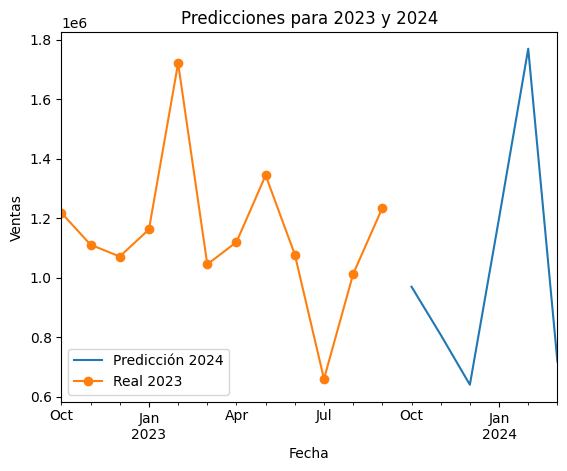

In [15]:
predicciones_2024_df.sum(axis=1).plot(label='Predicción 2024')   
df2023=df_ventas.loc['2022-10':'2023-09']
df2023.sum(axis=1).plot(label='Real 2023',marker='o')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Predicciones para 2023 y 2024')
plt.legend()
plt.show()

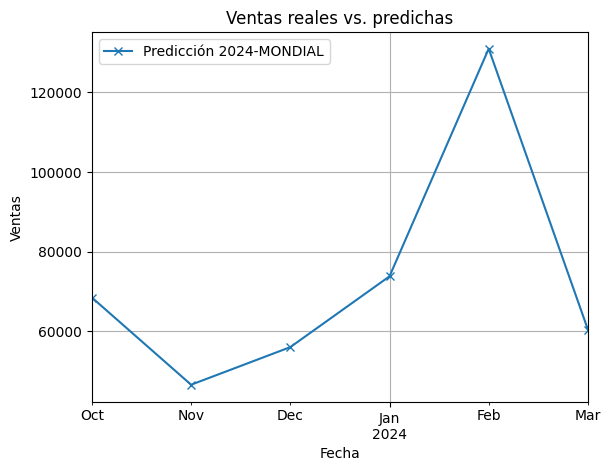

In [28]:
predicciones_2024_df['MONDIAL'].plot(label='Predicción 2024-MONDIAL',marker='x')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.title('Ventas reales vs. predichas')
plt.legend()


C:\Users\andre\AppData\Local\Temp\ipykernel_68896\1985046006.py:5: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  df_ventas_monthly = df_ventas.resample('M').sum()
C:\Users\andre\AppData\Local\Temp\ipykernel_68896\1985046006.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicciones_2023_df_monthly = predicciones_2023_df.resample('M').sum()


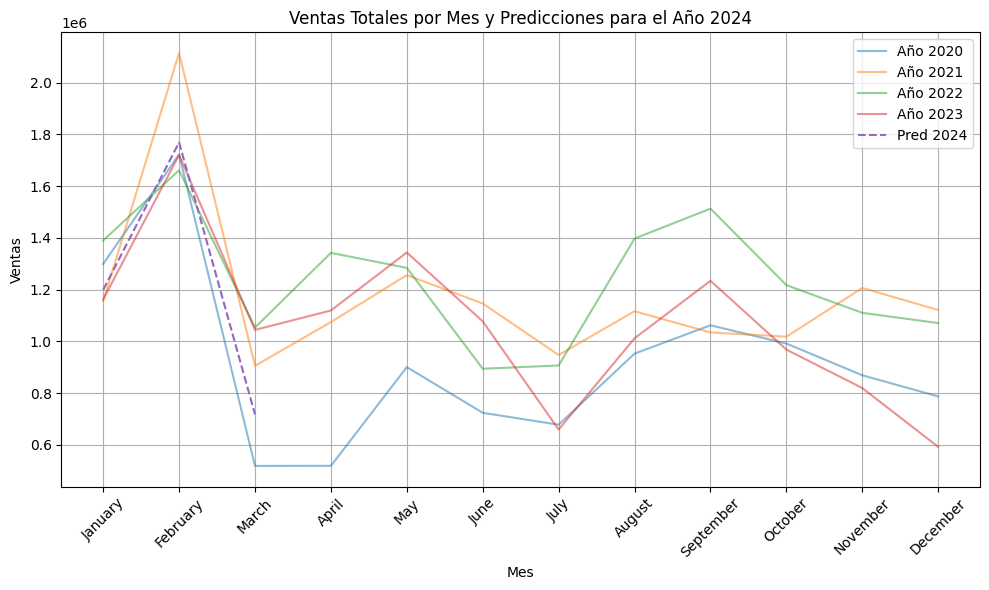

In [17]:
# Crear una figura y ejes
predicciones_2024_df_aux=predicciones_2024_df.loc['2024-01':'2024-09']
plt.figure(figsize=(10, 6))
ax = plt.gca()
df_ventas_monthly = df_ventas.resample('M').sum()
# Trazar las ventas reales del 2023 (mensuales)
predicciones_2023_df_monthly = predicciones_2023_df.resample('M').sum()
# Filtrar datos por año y sumar las ventas mensuales para cada año
for year in range(2020, 2024):
    yearly_sales = df_ventas_monthly[df_ventas_monthly.index.year == year].sum(axis=1)
    if not yearly_sales.empty:  # Verificar si hay datos para este año
        month_names = yearly_sales.index.strftime('%B')  # Obtener nombres completos de los meses
        plt.plot(month_names, yearly_sales.values, label=f'Año {year}', alpha=0.5)  # Hacer las ventas de años anteriores más transparentes

# Sumar todas las predicciones del 2024 por mes
total_predictions_2024 = predicciones_2024_df_aux.sum(axis=1)

# Graficar las predicciones totales para el año 2024
plt.plot(month_names[:3], total_predictions_2024, label='Pred 2024', linestyle='--')

plt.title('Ventas Totales por Mes y Predicciones para el Año 2024')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.xticks(rotation=45)  # Rotar nombres de los meses para mejor visualización
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [18]:
modelo.save('modelo_2023in.h5')

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
train_data_ventas = df_ventas.loc['2020-10':'2023-12']
train_data_produccion = df_produccion.loc['2020-10':'2023-12']

In [20]:
predicciones_2024_id = []
#variedad = 'MONDIAL'
for variedad in df_ventas.columns:
    endogena_train = train_data_ventas[variedad]
    exogena_train = train_data_produccion[variedad]
    train_generator = TimeseriesGenerator(np.column_stack((exogena_train, endogena_train)), endogena_train, length=1, batch_size=1)

    result = modelo.fit_generator(train_generator, epochs=100, verbose=0)

    # Predecir 12 puntos de datos para 2023
    pred_2024 = modelo.predict_generator(train_generator,steps=6)

    # Generar una predicción adicional para el último punto de tiempo en 2023


    # Guardar predicciones para 2023
    predicciones_variedad_2024 = {'variedad': variedad, 'predicciones_2024': pred_2024.flatten()}
    predicciones_2024_id.append(predicciones_variedad_2024)
winsound.Beep(2500, 1000) 


C:\Users\andre\AppData\Local\Temp\ipykernel_68896\3147940623.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = modelo.fit_generator(train_generator, epochs=100, verbose=0)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\sequence.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])
C:\Users\andre\AppData\Local\Temp\ipykernel_68896\3147940623.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_2024 = modelo.predict_generator(train_generator,steps=6)


In [21]:
predicciones_2024_df = pd.DataFrame(index=pd.date_range(start='2023-10', periods=6, freq='M'))

for result in predicciones_2024_id:
    variedad = result["variedad"]
    pred_2024 = result["predicciones_2024"]  # Truncar las predicciones para que tengan la misma longitud que el índice del DataFrame
    predicciones_2024_df[variedad] = pred_2024

C:\Users\andre\AppData\Local\Temp\ipykernel_68896\3115538396.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicciones_2024_df = pd.DataFrame(index=pd.date_range(start='2023-10', periods=6, freq='M'))


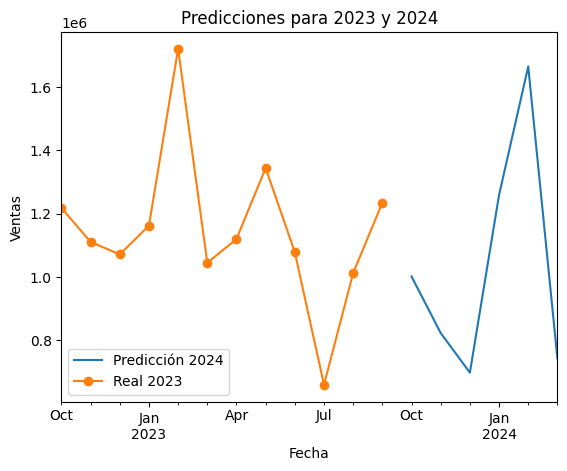

In [22]:
predicciones_2024_df.sum(axis=1).plot(label='Predicción 2024')   
df2023=df_ventas.loc['2022-10':'2023-09']
df2023.sum(axis=1).plot(label='Real 2023',marker='o')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Predicciones para 2023 y 2024')
plt.legend()
plt.show()

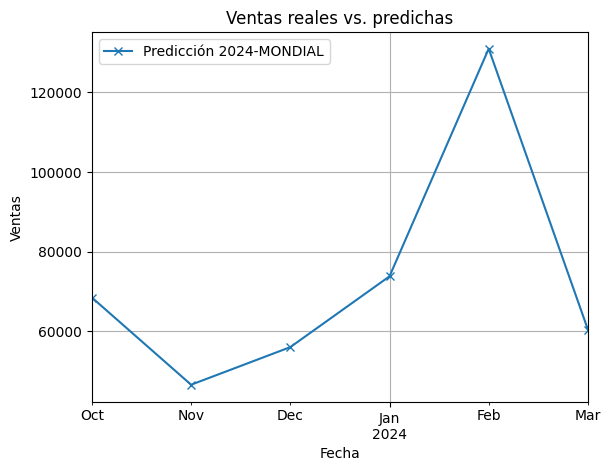

In [23]:
predicciones_2024_df['MONDIAL'].plot(label='Predicción 2024-MONDIAL',marker='x')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.title('Ventas reales vs. predichas')
plt.legend()


C:\Users\andre\AppData\Local\Temp\ipykernel_68896\2382405873.py:5: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  df_ventas_monthly = df_ventas.resample('M').sum()
C:\Users\andre\AppData\Local\Temp\ipykernel_68896\2382405873.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicciones_2023_df_monthly = predicciones_2023_df.resample('M').sum()


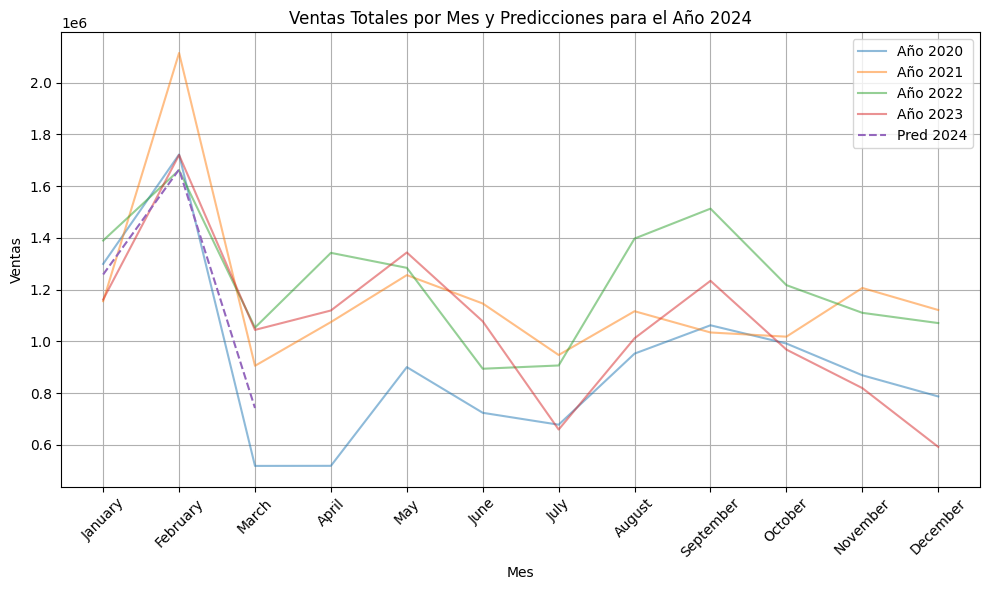

In [24]:
# Crear una figura y ejes
predicciones_2024_df_aux=predicciones_2024_df.loc['2024-01':'2024-12']
plt.figure(figsize=(10, 6))
ax = plt.gca()
df_ventas_monthly = df_ventas.resample('M').sum()
# Trazar las ventas reales del 2023 (mensuales)
predicciones_2023_df_monthly = predicciones_2023_df.resample('M').sum()
# Filtrar datos por año y sumar las ventas mensuales para cada año
for year in range(2020, 2024):
    yearly_sales = df_ventas_monthly[df_ventas_monthly.index.year == year].sum(axis=1)
    if not yearly_sales.empty:  # Verificar si hay datos para este año
        month_names = yearly_sales.index.strftime('%B')  # Obtener nombres completos de los meses
        plt.plot(month_names, yearly_sales.values, label=f'Año {year}', alpha=0.5)  # Hacer las ventas de años anteriores más transparentes

# Sumar todas las predicciones del 2024 por mes
total_predictions_2024 = predicciones_2024_df_aux.sum(axis=1)

# Graficar las predicciones totales para el año 2024
plt.plot(month_names[:3], total_predictions_2024, label='Pred 2024', linestyle='--')

plt.title('Ventas Totales por Mes y Predicciones para el Año 2024')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.xticks(rotation=45)  # Rotar nombres de los meses para mejor visualización
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [25]:
modelo.save('modelo_2023full.h5')

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
variedad='MONDIAL'
